# CS 195: Natural Language Processing
## Loading Data and Evaluating Classification Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericmanley/s26-CS195NLP/blob/main/F1_2_DataEvaluation.ipynb)


## References


Hugging Face *Load a dataset from the Hub tutorial*: https://huggingface.co/docs/datasets/load_hub

Arrow for datasets: https://huggingface.co/docs/datasets/about_arrow

scikit-learn *Classification Metrics User's Guide*: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

## Installing the datasets module

Hugging Face *also* provides a lot of data sets, and there's a module for that.

If you're running in a new environment (like Colab), you'll also have to install transformers again.

In [36]:
import sys
!{sys.executable} -m pip install transformers datasets accelerate scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 6.4 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 10.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 7.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


## Let's load the go_emotions dataset

The *go_emotions* dataset is a set of Reddit comments that have been labeled with 28 categories (27 emotions + neutral). 

See more here: https://huggingface.co/datasets/go_emotions


In [2]:
from datasets import load_dataset

dataset = load_dataset("go_emotions")

/home/evan/evan-drake/cs-195/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 5427/5427 [00:00<00:00, 358673.37 examples/s]


## Let's explore the dataset

What does it look like when printed/displayed?

In [3]:
print(dataset)
print(type(dataset))

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
<class 'datasets.dataset_dict.DatasetDict'>


It seems that Hugging Face has defined a special datatype for representing a dataset - `DatasetDict`

They've divided it into three parts:
* **train:** these should be used to train models
* **validation:** these should be used for testing model in the middle of training (for picking the right metaparameters, etc.)
* **test:** these should be used to evaluate the model

**Group Discussion Question:** Why is it important to train and test models on different data? Why do you think they have pre-split this dataset?

### Now let's access the test set

In [4]:
print(dataset["test"])

Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 5427
})


and from there, we can use subscript notation to access the text, labels, and ids

What are the types of these things?

In [5]:
print( type(dataset["test"]["text"]) )
print( type(dataset["test"]["labels"]) )
print( type(dataset["test"]["id"]) )

<class 'datasets.arrow_dataset.Column'>
<class 'datasets.arrow_dataset.Column'>
<class 'datasets.arrow_dataset.Column'>


The **Column** data type is a fast, read-only, list-like view of data (similar to a Pandas Series) that is *lazy* (data isn’t loaded into memory until needed) and [*zero copy*](https://en.wikipedia.org/wiki/Zero-copy) (it avoids unnecessary data duplication)

It's backed by a data format called [Apache Arrow](https://arrow.apache.org/docs/python/index.html)

But, we can use them like lists:

In [6]:
print("The first 5 texts:")
print( dataset["test"]["text"][0:5] )

print("\nThe first 5 labels:")
print( dataset["test"]["labels"][0:5] )

print("\nThe first 5 ids:")
print( dataset["test"]["id"][0:5] )

The first 5 texts:
['I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!', "It's wonderful because it's awful. At not with.", 'Kings fan here, good luck to you guys! Will be an interesting game to watch! ', "I didn't know that, thank you for teaching me something today!", 'They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.']

The first 5 labels:
[[25], [0], [13], [15], [27]]

The first 5 ids:
['eecwqtt', 'ed5f85d', 'een27c3', 'eelgwd1', 'eem5uti']


They also made it possible to select/slice on the Dataset object itself.

In [7]:
dataset["test"][0:5]

{'text': ['I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!',
  "It's wonderful because it's awful. At not with.",
  'Kings fan here, good luck to you guys! Will be an interesting game to watch! ',
  "I didn't know that, thank you for teaching me something today!",
  'They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.'],
 'labels': [[25], [0], [13], [15], [27]],
 'id': ['eecwqtt', 'ed5f85d', 'een27c3', 'eelgwd1', 'eem5uti']}

But which emotions are represented by those numbers 25, 0, 13, 15, and 27?

A `dataset` has a `features` attribute which stores this information

In [9]:
dataset["test"].features

{'text': Value('string'),
 'labels': List(ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'])),
 'id': Value('string')}

and you can get the string for an individual feature like this:

In [13]:
dataset["test"].features["labels"].feature.int2str(25)

'sadness'

## Group Activity

Other datasets structure themselves differently, and you will have to explore them to understand how to work with them properly. 

Here's other datasets we could try: 
* https://huggingface.co/datasets/SetFit/bbc-news
* https://huggingface.co/datasets/stanfordnlp/sst2

Start with this code and try some of the things we did above. What's different?

In [28]:
other_dataset = load_dataset("SetFit/bbc-news")

# print(other_dataset)

# print(other_dataset["train"][0:50])
print(other_dataset["train"][0:50]["label"])
print(other_dataset["train"][0:50]["label_text"])
# print(other_dataset["train"].features)

# mapping of numbers to labels
print(sorted(set(zip(other_dataset["train"][0:50]["label"], other_dataset["train"][0:50]["label_text"]))))


[2, 1, 3, 1, 0, 4, 3, 3, 4, 1, 0, 0, 0, 2, 3, 0, 2, 0, 1, 3, 4, 1, 0, 2, 1, 0, 0, 2, 1, 2, 3, 4, 2, 4, 2, 4, 2, 3, 1, 4, 2, 3, 2, 1, 2, 3, 2, 3, 2, 0]
['sport', 'business', 'entertainment', 'business', 'tech', 'politics', 'entertainment', 'entertainment', 'politics', 'business', 'tech', 'tech', 'tech', 'sport', 'entertainment', 'tech', 'sport', 'tech', 'business', 'entertainment', 'politics', 'business', 'tech', 'sport', 'business', 'tech', 'tech', 'sport', 'business', 'sport', 'entertainment', 'politics', 'sport', 'politics', 'sport', 'politics', 'sport', 'entertainment', 'business', 'politics', 'sport', 'entertainment', 'sport', 'business', 'sport', 'entertainment', 'sport', 'entertainment', 'sport', 'tech']
[(0, 'tech'), (1, 'business'), (2, 'sport'), (3, 'entertainment'), (4, 'politics')]


## Using the dataset with a model

So, let's put it all together

In [29]:
from transformers import pipeline
from datasets import load_dataset
from accelerate import Accelerator

device = Accelerator().device

dataset = load_dataset("go_emotions")
classifier = pipeline("sentiment-analysis", model="SamLowe/roberta-base-go_emotions", device=device)

results = classifier(dataset["test"]["text"][0:5])
print("Here are the predictions")
print(results)

total_correct = 0

#comparing to the actual labels
for idx in range (5):
    print("\nText:",dataset["test"]["text"][idx])
    predicted_label = results[idx]["label"]
    actual_label_numeric = dataset["test"]["labels"][idx][0]
    actual_label = dataset["test"].features["labels"].feature.int2str( actual_label_numeric )
    print("Predicted label:",predicted_label,", Actual label:",actual_label)
    if predicted_label == actual_label:
        total_correct += 1
        
print("Accuracy:",(total_correct/5))

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 348.94it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForSequenceClassification LOAD REPORT from: SamLowe/roberta-base-go_emotions
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Here are the predictions
[{'label': 'remorse', 'score': 0.6783007383346558}, {'label': 'admiration', 'score': 0.6606237292289734}, {'label': 'optimism', 'score': 0.5494067668914795}, {'label': 'gratitude', 'score': 0.9829797744750977}, {'label': 'neutral', 'score': 0.8685782551765442}]

Text: I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
Predicted label: remorse , Actual label: sadness

Text: It's wonderful because it's awful. At not with.
Predicted label: admiration , Actual label: admiration

Text: Kings fan here, good luck to you guys! Will be an interesting game to watch! 
Predicted label: optimism , Actual label: excitement

Text: I didn't know that, thank you for teaching me something today!
Predicted label: gratitude , Actual label: gratitude

Text: They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.
Predicted label: neutral , Actual label: neutral
Accuracy: 0.6


**Test it out:** Do this for a larger portion of the test set (it might take a while)
- This will go faster if you can run on a GPU/TPU
- In Colab, do Runtime -> Change runtime type (The pipeline should automatically try to use a GPU if it is available)
- Comment out the print statements for individual results

## Making it work with the scikit-learn metrics

**Review:** The `scikit-learn` library has lots of functions for calculating metrics of machine-learning predictions. 

Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

To get this to work with our experiment, just make lists for your predicted and actual labels

In [30]:
from transformers import pipeline
from datasets import load_dataset
from accelerate import Accelerator

device = Accelerator().device

dataset = load_dataset("go_emotions")
classifier = pipeline("sentiment-analysis", model="SamLowe/roberta-base-go_emotions", device=device)

results = classifier(dataset["test"]["text"][0:1000])

predicted_labels = []
actual_labels = []

for idx in range(1000):
    predicted_labels.append(results[idx]["label"])
    actual_label_numeric = dataset["test"]["labels"][idx][0]
    actual_labels.append( dataset["test"].features["labels"].feature.int2str( actual_label_numeric ) )
    


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 659.22it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForSequenceClassification LOAD REPORT from: SamLowe/roberta-base-go_emotions
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


### accuracy

Now we can calculate accuracy using `sklearn`'s `accuracy_score`

In [33]:
from sklearn.metrics import accuracy_score

print("Accuracy:",accuracy_score(actual_labels,predicted_labels) )

Accuracy: 0.593


This seems pretty good for 28 categories

if you were just guessing randomly, you'd get 1/28 ~= 0.036

if you always guess the most common label (neutral), you'd get ~ 0.30

### precision, recall, f1 scores

You can display all of these with the classification report - higher numbers are better.

**precision:** Of all the instances that the model predicted as **admiration**, how many were actually **admiration**?

**recall:** Of all the actual **admiration** instances in the dataset, how many did the model correctly predict as **admiration**?

**f1:** Combination balancing *precision* and *recall*

In [34]:
from sklearn.metrics import classification_report

print(classification_report(actual_labels,predicted_labels,zero_division=0))

                precision    recall  f1-score   support

    admiration       0.68      0.62      0.65        82
     amusement       0.74      0.87      0.80        39
         anger       0.67      0.41      0.51        39
     annoyance       0.41      0.27      0.33        51
      approval       0.44      0.36      0.40        45
        caring       0.53      0.34      0.42        29
     confusion       0.44      0.57      0.50        21
     curiosity       0.47      0.50      0.49        38
        desire       0.53      0.50      0.51        18
disappointment       0.43      0.35      0.39        17
   disapproval       0.51      0.50      0.51        46
       disgust       0.56      0.48      0.51        21
 embarrassment       0.80      0.57      0.67         7
    excitement       0.54      0.54      0.54        13
          fear       0.65      0.65      0.65        20
     gratitude       0.86      0.88      0.87        69
         grief       0.00      0.00      0.00  

It seems to perform well on emotions like amusement and gratitude, but not as well on realization or annoyance.

### confusion matrix

display a confusion matrix to see which labels are getting confused with others

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

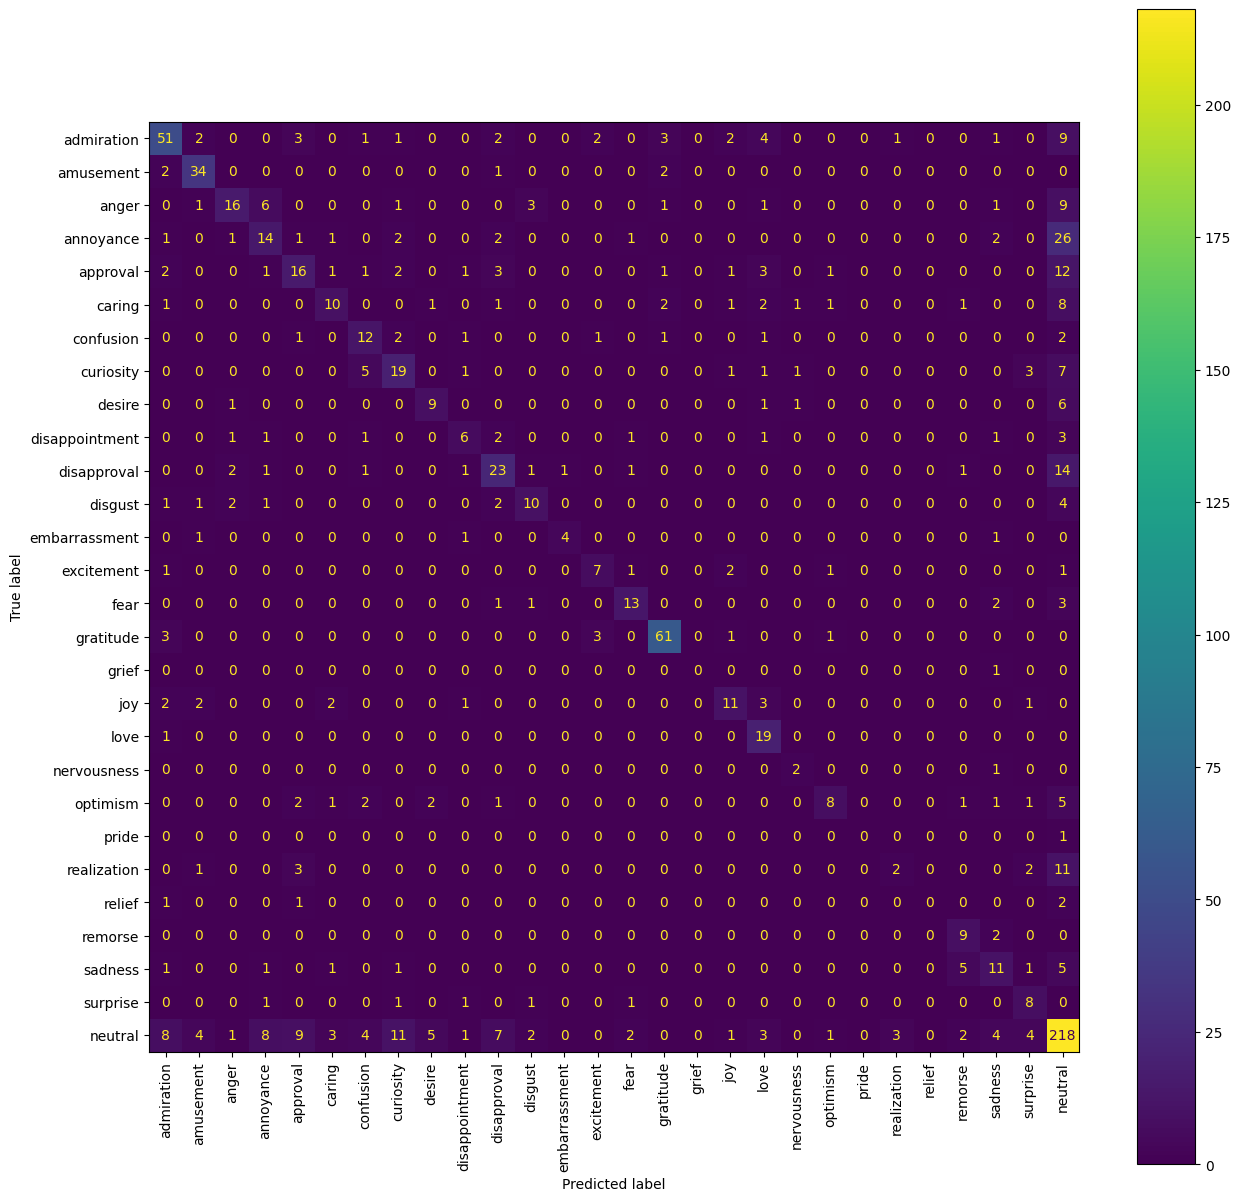

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label_names = dataset["test"].features["labels"].feature.names
fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(actual_labels,predicted_labels,labels=label_names)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
cmd.plot(ax=ax,xticks_rotation='vertical',)

plt.show()

neutral is the most common, so it gets confused with others most

also notice sometimes others get confused: love and approval, optimism and desire, etc.

## Group work

Choose **two** of the new *text classification* models your group experimented with last week that you can find the datasets for (https://huggingface.co/datasets if not linked directly).

Split into two subgroups
* each subgroup: evaluate one of the models using the metrics shown here

**Prepare to debrief:** I will have you present at least one set of results per group.

## If you have time, experiment with running inference on other datasets

Let's do this again, but use the default positive/negative sentiment analysis model and see how it does with the `go_emotions` data.

We do need to tell the confusion matrix about the labels from the classifier too: `["POSITIVE","NEGATIVE"]`

In [8]:
from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from accelerate import Accelerator

device = Accelerator().device

dataset = load_dataset("mshenoda/spam-messages")
classifier = pipeline("sentiment-analysis", model="mshenoda/roberta-spam" ,device=device)

trimmed_dataset = list(zip(dataset["test"]["label"][0:1000], dataset["test"]["text"][0:1000]))
print(trimmed_dataset)
results = classifier([row[0] for row in trimmed_dataset])

predicted_labels = []
actual_labels = []

for idx in range(1000):
    predicted_labels.append(results[idx]["label"])
    actual_label_numeric = dataset["test"]["label"][idx][0]
    actual_labels.append( dataset["test"].features["label"].feature.int2str( actual_label_numeric ) )
    
print(accuracy_score(actual_labels, predicted_labels))
# label_names = ["POSITIVE","NEGATIVE"]+dataset["test"].features["labels"].feature.names
# fig, ax = plt.subplots(figsize=(15, 15))
# cm = confusion_matrix(actual_labels,predicted_labels,labels=label_names)
# cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
# cmd.plot(ax=ax,xticks_rotation='vertical',)

# plt.show()

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 641.10it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForSequenceClassification LOAD REPORT from: mshenoda/roberta-spam
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[('ham', 'Yeah why not, is the gang all ready'), ('ham', 'No message..no responce..what happend?'), ('ham', 'Ron say fri leh. N he said ding tai feng cant make reservations. But he said wait lor.'), ('ham', "K come to nordstrom when you're done"), ('ham', 'Damn, can you make it tonight or do you want to just wait til tomorrow'), ('ham', "I'm on da bus going home..."), ('ham', "No idea, I guess we'll work that out an hour after we're supposed to leave since as usual nobody has any interest in figuring shit out before the last second"), ('ham', 'Come to my home for one last time i wont do anything. Trust me.'), ('ham', 'Now press conference da:)'), ('ham', "Stop calling everyone saying I might have cancer. My throat hurts to talk. I can't be answering everyones calls. If I get one more call I'm not babysitting on Monday"), ('ham', 'Nope... Juz off from work...'), ('ham', 'Hmmm:)how many players selected?'), ('ham', "Also remember to get dobby's bowl from your car"), ('ham', 'I am in esca

AttributeError: 'Value' object has no attribute 'feature'

emotions like anger, annoyance, and disapproval often result in a NEGATIVE prediction

admiration, gratitude, and love often result in a POSITIVE prediction

You could manually sort the emotions into POSITIVE and NEGATIVE and run your own experiment to measure how well it does on this data.

## Applied Exploration

Go to the Hugging Face models page: https://huggingface.co/models
* Click `Text Classification`
* Find a different model and a dataset appropriate for testing it with than the ones we worked with today
    - many models will link to the datasets they were trained on, but you can find others at https://huggingface.co/datasets
    - write down some info about the models you found
        - what is it for?
        - who made it?
        - what kind of data was it trained on?
        - are they based on some other model and trained on new data (*fine-tuned*) for a specific task?
    - write down some info on the dataset you found
        - where did it come from?
        - how big is it?
        - what kind of labels does it classify?
* Evaluate the performance 
    - use some of the metrics we talked about today
    - describe in your own words how it performed
    